In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "TRB_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-Myositis-TRB_HUMAN-after-reassignment.csv']

In [3]:
pt_file="20220509-DataSheet-RUN46.csv"
run = "run46"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: run46-similarity-TRB_HUMAN.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,E2134-17-Th_S155,ACGTACGT,CASSLLSSGANVLTFG,48,21,TRBV27,TRBJ2-6,48,1.0,25.945946,25.000000
1,E2134-17-Th_S155,ACGTACGT,CASSGTVNEQFFG,14,3,TRBV6-5,TRBJ2-1,14,1.0,7.567568,3.571429
2,E2134-17-Th_S155,ACGTACGT,CASSMGREDYEQYFG,11,4,TRBV19,TRBJ2-7,0,0.0,5.945946,4.761905
3,E2134-17-Th_S155,ACGTACGT,CASSQARTGLNYEQYFG,8,3,TRBV13,TRBJ2-7,8,1.0,4.324324,3.571429
4,E2134-17-Th_S155,ACGTACGT,CSVEDGGRTGSYNEQFFG,8,2,TRBV29-1,TRBJ2-1,16,2.0,4.324324,2.380952


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
244762,T19-00509-Th_S154,CATSESVNTGELFFG,97,68,97,1.0,6.968391,7.971864
244545,T19-00509-Th_S154,CASSLRVSGGTHNEQFFG,54,33,54,1.0,3.879310,3.868699
244510,T19-00509-Th_S154,CASSKAHDSTDTQYFG,53,48,53,1.0,3.807471,5.627198
244655,T19-00509-Th_S154,CASSRTGDSSYEQYFG,50,28,50,1.0,3.591954,3.282532
244832,T19-00509-Th_S154,CSVEFPTGELFFG,29,12,58,2.0,2.083333,1.406800


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=",", skiprows=20)
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Run,Nr,Sample_Project,Species,Chain,Patient,SampleInfo,UMI,HEK_cells,Constant,RACE,MID
0,N701_S502,T2B006-U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S1,Target2B,human,BCRh,17,HC,yes,no,no,no,NaN
1,N702_S502,T2B008-U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S2,Target2B,human,BCRh,110,PF29,yes,no,no,no,NaN
2,N703_S502,T2B009-U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S3,Target2B,human,BCRh,137,PV26 01,yes,no,no,no,NaN
3,N704_S502,T2B010-U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S4,Target2B,human,BCRh,156,B14 18-4-2012 (v7),yes,no,no,no,NaN
4,N705_S502,T2B012-U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S5,Target2B,human,BCRh,172,B53 28-3-2011 (v7),yes,no,no,no,NaN


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample_Name'], pt['Nr'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,T2B006-U_S1,17
1,T2B008-U_S2,110
2,T2B009-U_S3,137
3,T2B010-U_S4,156
4,T2B012-U_S5,172


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,T19-00509-Th_S154,CATSESVNTGELFFG,97,68,97,1.0,6.968391,7.971864,MYO115
1,T19-00509-Th_S154,CASSLRVSGGTHNEQFFG,54,33,54,1.0,3.879310,3.868699,MYO115
2,T19-00509-Th_S154,CASSKAHDSTDTQYFG,53,48,53,1.0,3.807471,5.627198,MYO115
3,T19-00509-Th_S154,CASSRTGDSSYEQYFG,50,28,50,1.0,3.591954,3.282532,MYO115
4,T19-00509-Th_S154,CSVEFPTGELFFG,29,12,58,2.0,2.083333,1.406800,MYO115


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                         MYO101                                    \
Sample             MYO101base2-Th_S133 MYO101end-T_S95 T17-04319-Th_S136   
cdr3pep                                                                    
CAAAASGRAQRTGELFFG                 0.0             0.0               0.0   
CAAAASGSEQFFG                      0.0             0.0               0.0   
CAAAEGPTYEQYFG                     0.0             0.0               0.0   
CAAAGGAGSNQPQHFG                   0.0             0.0               0.0   
CAAAGGYNEQFFG                      0.0             0.0               0.0   

Patient                         MYO102                                   \
Sample             MYO102base2-Th_S134 MYO102end-T_S96 T17-06816-T_S124   
cdr3pep                                                                   
CAAAASGRAQRTGELFFG                 0.0             0.0              0.0   
CAAAASGSEQFFG                      0.0             0.0              0.0   
CAAAEGPTYEQYFG                     0.0             0.0              0.0   
CAAAGGAGSNQPQHFG                   0.0             0.0              0.0   
CAAAGGYNEQFFG                      0.0             0.0              0.0   

Patient                      MYO103                                    \
Sample             MYO103base-T_S66 MYO103end-T_S97 T17-07401-Th_S137   
cdr3pep                                                                 
CAAAASGRAQRTGELFFG              1.0             0.0               0.0   
CAAAASGSEQFFG                   0.0             0.0               0.0   
CAAAEGPTYEQYFG                  0.0             0.0               0.0   
CAAAGGAGSNQPQHFG                0.0             0.0               0.0   
CAAAGGYNEQFFG                   0.0             0.0               0.0   

Patient                      MYO104  ...           MYO201                   \
Sample             MYO104base-T_S67  ... MYO201base-T_S91 MYO201end-T_S122   
cdr3pep                              ...                                     
CAAAASGRAQRTGELFFG              0.0  ...              0.0              0.0   
CAAAASGSEQFFG                   0.0  ...              0.0              0.0   
CAAAEGPTYEQYFG                  0.0  ...              0.0              0.0   
CAAAGGAGSNQPQHFG                0.0  ...              0.0              0.0   
CAAAGGYNEQFFG                   0.0  ...              0.0              0.0   

Patient                      MYO202                            MYO203  \
Sample             E2134-39-Th_S156 MYO202base-T_S92 E2208-34-Th_S157   
cdr3pep                                                                 
CAAAASGRAQRTGELFFG              0.0              0.0              0.0   
CAAAASGSEQFFG                   0.0              0.0              0.0   
CAAAEGPTYEQYFG                  0.0              0.0              0.0   
CAAAGGAGSNQPQHFG                0.0              0.0              0.0   
CAAAGGYNEQFFG                   0.0              0.0              0.0   

Patient                                                          MYO301  \
Sample             MYO203base-T_S93 MYO203end2-Th_S135 MYO301base-T_S94   
cdr3pep                                                                   
CAAAASGRAQRTGELFFG              0.0                0.0              0.0   
CAAAASGSEQFFG                   0.0                0.0              0.0   
CAAAEGPTYEQYFG                  0.0                1.0              0.0   
CAAAGGAGSNQPQHFG                0.0                0.0              0.0   
CAAAGGYNEQFFG                   0.0                1.0              0.0   

Patient                                                
Sample             MYO301end-T_S123 Pt301UMCG-Th_S158  
cdr3pep                                                
CAAAASGRAQRTGELFFG              0.0               0.0  
CAAAASGSEQFFG                   0.0               0.0  
CAAAEGPTYEQYFG                  0.0               0.0  
CAAAGGAGSNQPQHFG                0.0               0.0  
CA

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                                  MYO101                  \
Sample                      MYO101base2-Th_S133 MYO101end-T_S95   
Patient Sample                                                    
MYO101  MYO101base2-Th_S133            1.000000        0.060900   
        MYO101end-T_S95                0.060900        1.000000   
        T17-04319-Th_S136              0.062500        0.018379   
MYO102  MYO102base2-Th_S134            0.000467        0.004373   
        MYO102end-T_S96                0.000863        0.003783   

Patient                                                    MYO102  \
Sample                      T17-04319-Th_S136 MYO102base2-Th_S134   
Patient Sample                                                      
MYO101  MYO101base2-Th_S133          0.062500            0.000467   
        MYO101end-T_S95              0.018379            0.004373   
        T17-04319-Th_S136            1.000000            0.000339   
MYO102  MYO102base2-Th_S134          0.000339            1.000000   
        MYO102end-T_S96              0.000244            0.090259   

Patient                                                                MYO103  \
Sample                      MYO102end-T_S96 T17-06816-T_S124 MYO103base-T_S66   
Patient Sample                                                                  
MYO101  MYO101base2-Th_S133        0.000863         0.000264         0.001791   
        MYO101end-T_S95            0.003783         0.002917         0.006435   
        T17-04319-Th_S136          0.000244         0.000306         0.000525   
MYO102  MYO102base2-Th_S134        0.090259         0.035113         0.007631   
        MYO102end-T_S96            1.000000         0.039454         0.005669   

Patient                                                        \
Sample                      MYO103end-T_S97 T17-07401-Th_S137   
Patient Sample                                                  
MYO101  MYO101base2-Th_S133        0.000944          0.003200   
        MYO101end-T_S95            0.004540          0.002983   
        T17-04319-Th_S136          0.000377          0.007308   
MYO102  MYO102base2-Th_S134        0.003963          0.001807   
        MYO102end-T_S96            0.002909          0.002563   

Patient                               MYO104  ...           MYO201  \
Sample                      MYO104base-T_S67  ... MYO201base-T_S91   
Patient Sample                                ...                    
MYO101  MYO101base2-Th_S133         0.001412  ...         0.001003   
        MYO101end-T_S95             0.002361  ...         0.003321   
        T17-04319-Th_S136           0.002250  ...         0.000192   
MYO102  MYO102base2-Th_S134         0.001980  ...         0.005895   
        MYO102end-T_S96             0.001677  ...         0.004120   

Patient                                                MYO202  \
Sample                      MYO201end-T_S122 E2134-39-Th_S156   
Patient Sample                                                  
MYO101  MYO101base2-Th_S133         0.001126         0.001134   
        MYO101end-T_S95             0.002221         0.001207   
        T17-04319-Th_S136           0.001404         0.008463   
MYO102  MYO102base2-Th_S134         0.002815         0.000000   
        MYO102end-T_S96             0.002991         0.000944   

Patient                                                MYO203  \
Sample                      MYO202base-T_S92 E2208-34-Th_S157   
Patient Sample                                                  
MYO101  MYO101base2-Th_S133         0.000873         0.000000   
        MYO101end-T_S95             0.003650         0.001691   
        T17-04319-Th_S136           0.000158         0.000000   
MYO102  MYO102base2-Th_S134         0.006490         0.002697   
        MYO102end-T_S96             0.004988         0.002044   

Patient                                                          \
Sample                      MYO203base-T_S93 MYO203end2-Th_S135   
Pat

In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote run46-similarity-TRB_HUMAN.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 8.725242125473542e-05
max value: 1.0
Wrote run46-similarity-TRB_HUMAN.pdf to disk


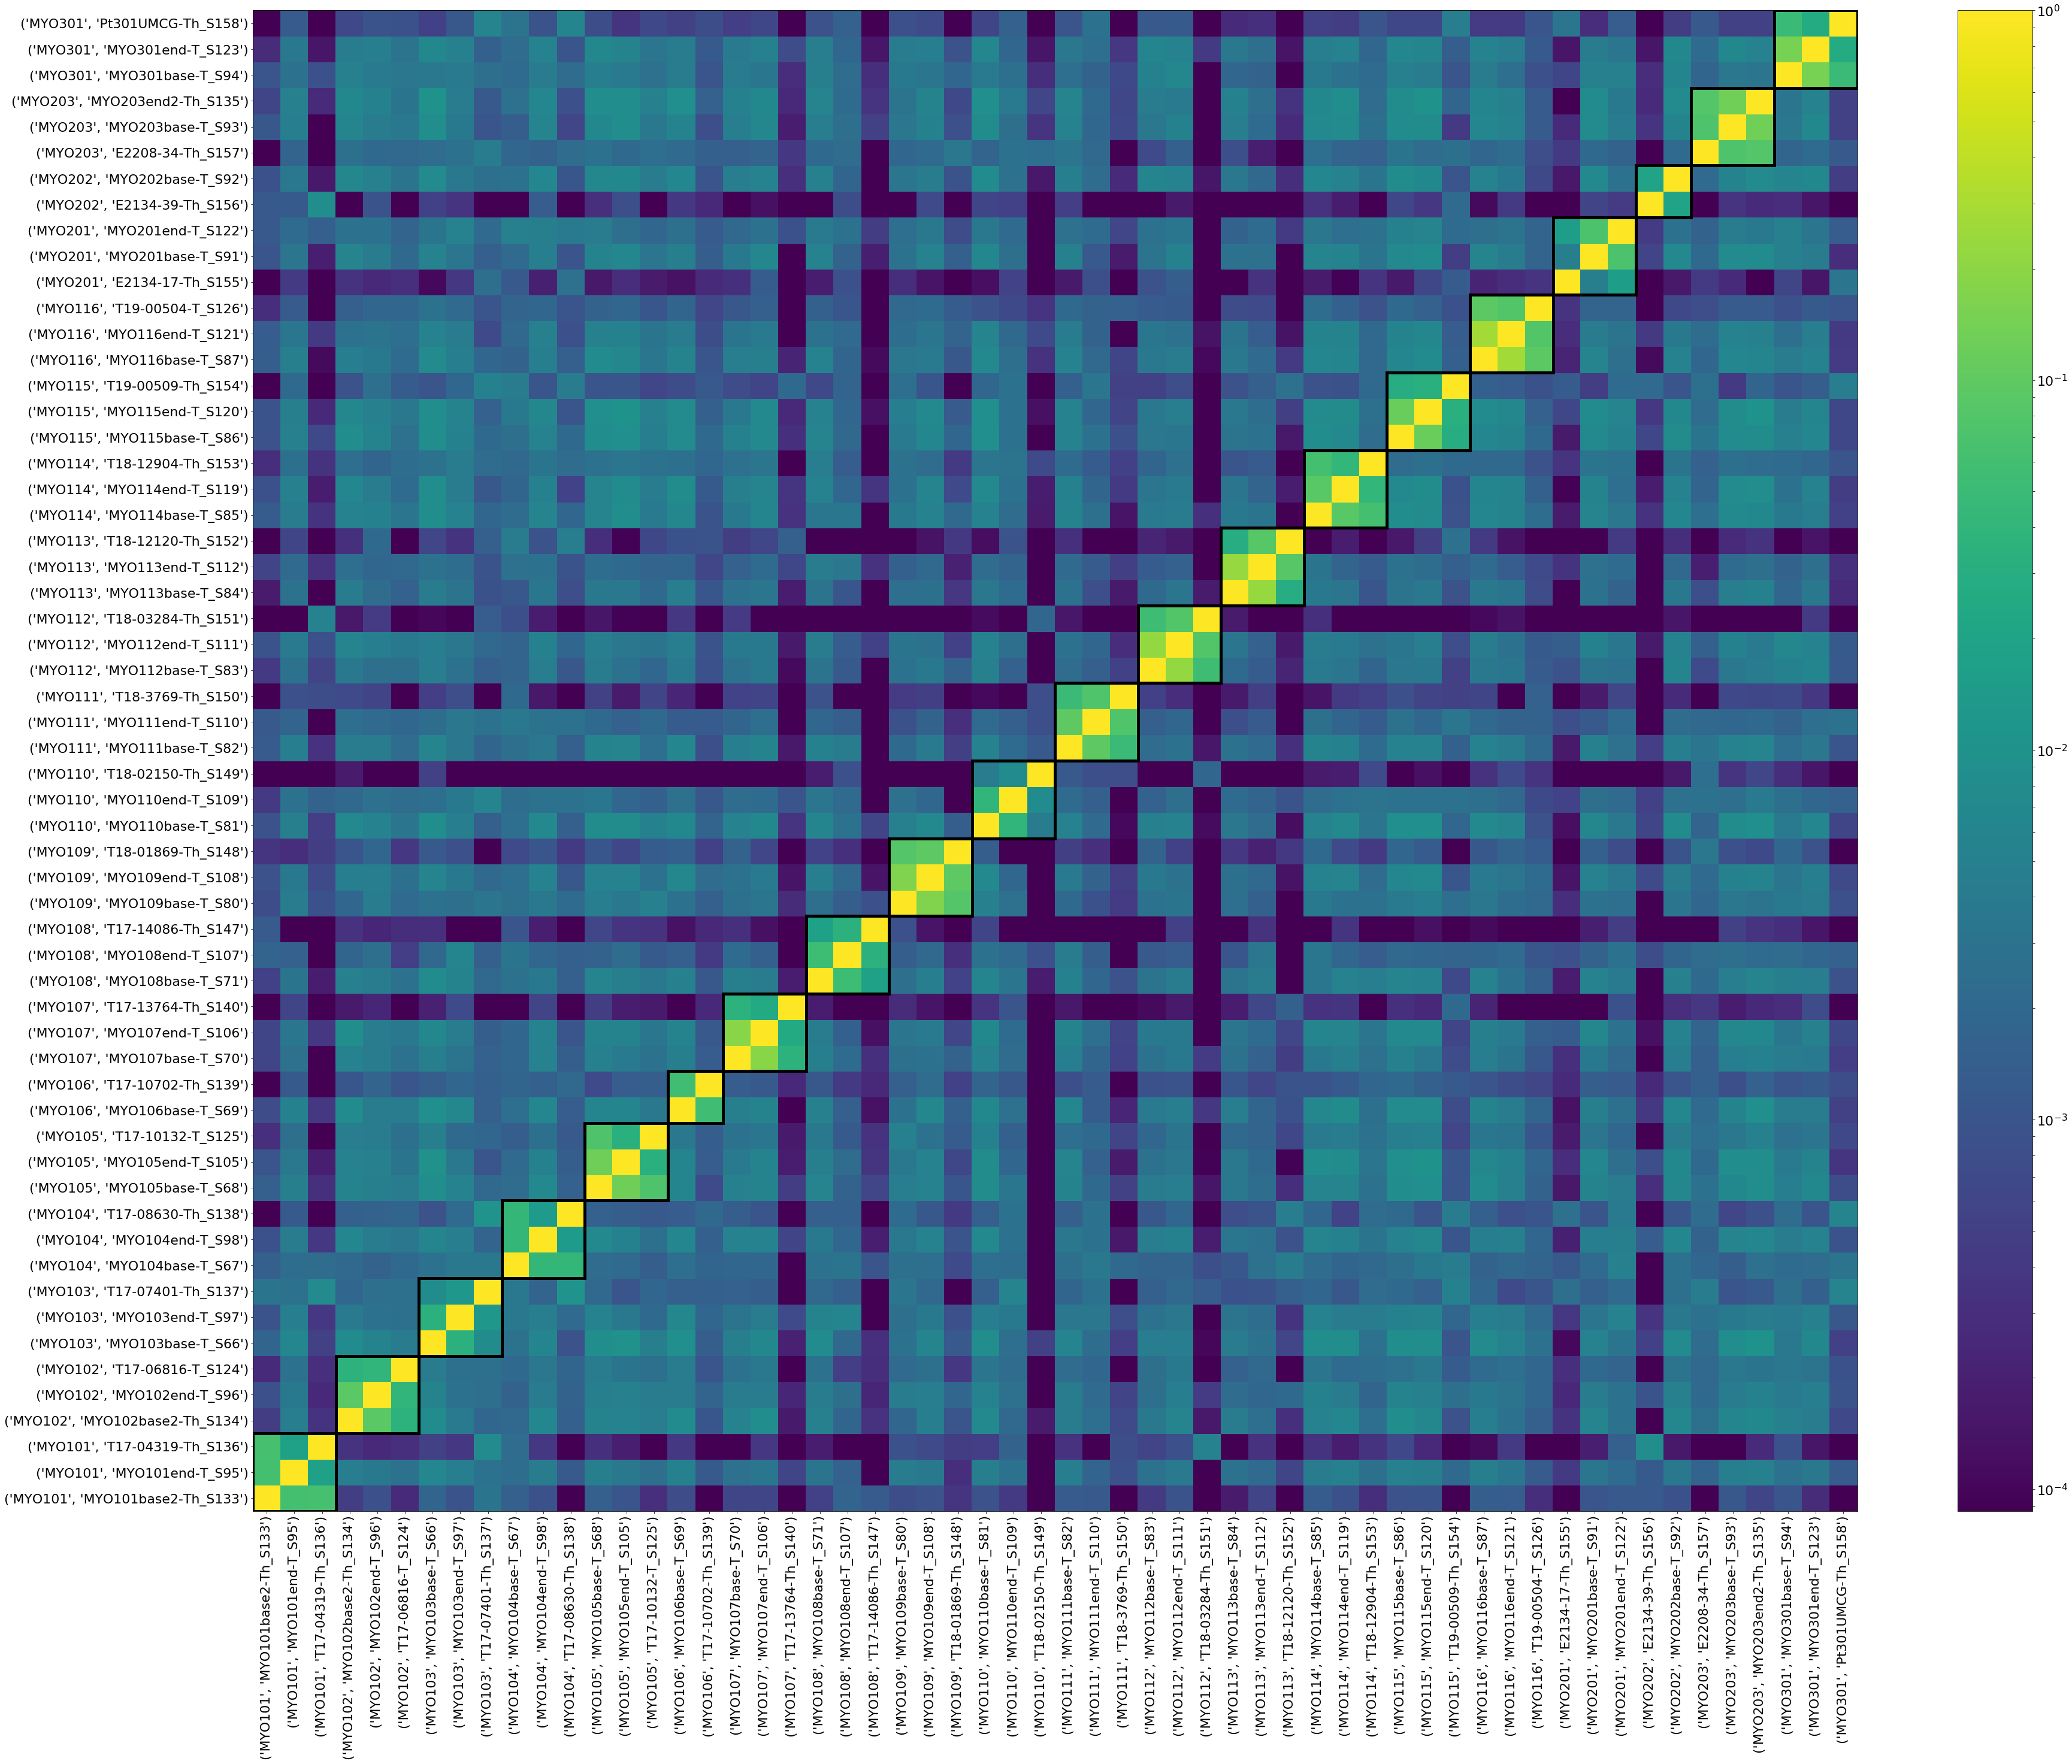

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.06899197539496506 0.057983166016099374
mean diff patient 0.00240118486106833 0.0021900441982452214
threshold 0.011161361654049216


{'boxes': [<matplotlib.lines.Line2D at 0x7f94e25fc6a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f94e25840f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f94e2584d68>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f94e2584940>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f94e25fc7f0>,
  <matplotlib.lines.Line2D at 0x7f94e258da58>]}

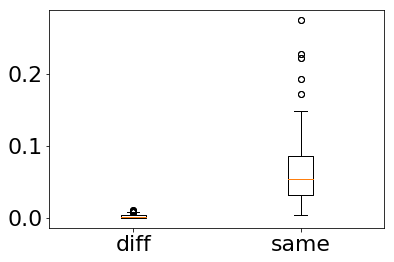

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

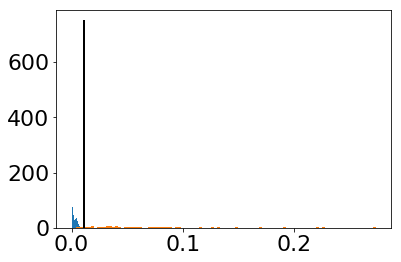

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

Wrote run46-similarity-TRB_HUMAN.txt to disk


In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 8.725242125473542e-05
max value: 1.0
Wrote run46-similarity-TRB_HUMAN-highlighted.pdf to disk


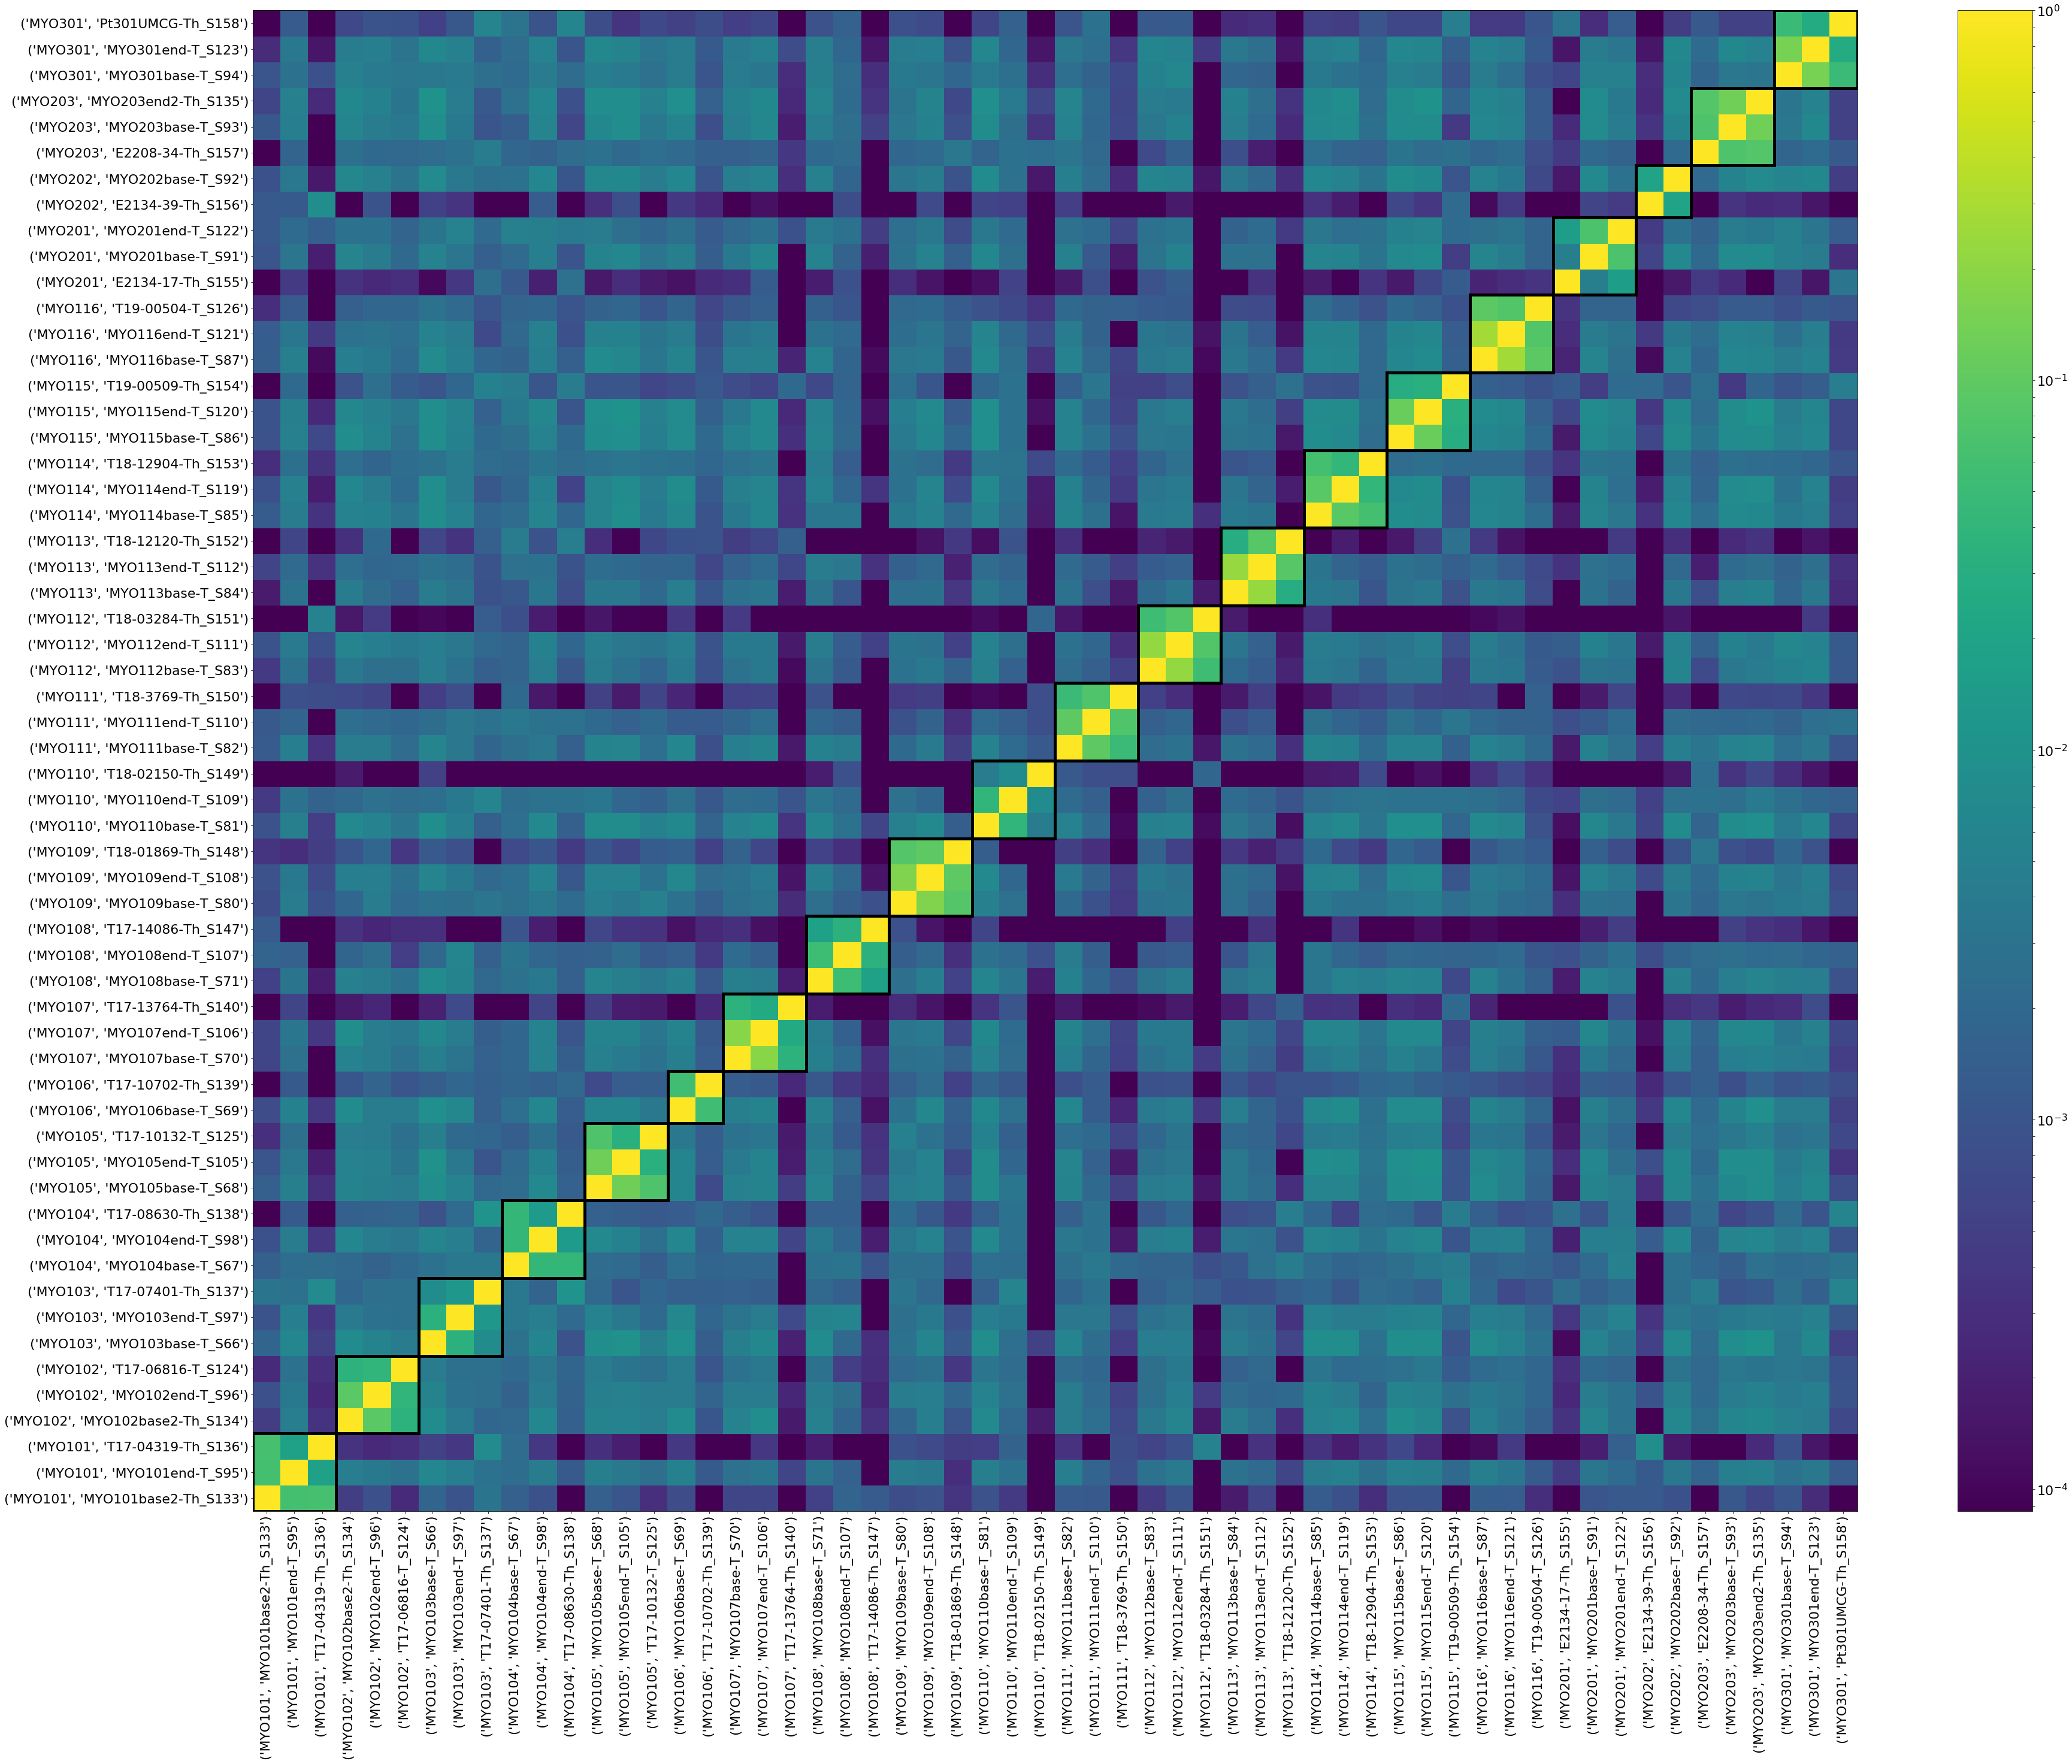

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)